In [1]:
import torch
import numpy as np
from torch import nn
import torchvision
from torchvision import transforms, datasets
from torch import optim
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
from matplotlib import pyplot as plt

In [3]:
import torch.nn.functional as F

In [4]:
transform = transforms.Compose([transforms.ToTensor()])

In [5]:
trainset= datasets.MNIST('~/.pytorch/MNIST/', train=True, download=True, transform=transform)

validset= datasets.MNIST('~/.pytorch/MNIST/', train=True, download=True, transform=transform)

testset= datasets.MNIST('~/.pytorch/MNIST/', train=False, download=True,transform=transform)

In [6]:
batch_size = 100
pin_memory = 1
num_workers = 1

In [7]:
# train_loader = torch.utils.data.DataLoader(
#     trainset, batch_size=batch_size,
#     num_workers=num_workers, pin_memory=pin_memory,
# )

In [8]:
num_train = len(trainset)
num_test = len(testset)
indices = list(range(num_train))
split = int(np.floor(0.3 * num_train))

np.random.seed(42)
np.random.shuffle(indices)

In [9]:
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, sampler=train_sampler,
    num_workers=num_workers, pin_memory=pin_memory,
)
valid_loader = torch.utils.data.DataLoader(
    validset, batch_size=batch_size, sampler=valid_sampler,
    num_workers=num_workers, pin_memory=pin_memory,
)

test_loader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, num_workers=num_workers, 
    pin_memory=pin_memory, shuffle=True
)

In [10]:
for imgs,labels in train_loader:
    print(imgs.shape,labels.shape)
    break

torch.Size([100, 1, 28, 28]) torch.Size([100])


In [23]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn1 = nn.Conv2d(1,2,kernel_size=3,padding=1)
        self.cnn2 = nn.Conv2d(2,4,kernel_size=3,padding=1)
        self.cnn3 = nn.Conv2d(4,10,kernel_size=3,padding=1)

        self.pool = nn.MaxPool2d(2,return_indices=True)
        
        self.unpool = nn.MaxUnpool2d(2)
        
        self.t_cnn1 = nn.ConvTranspose2d(10,4,kernel_size=3,padding=1)
        self.t_cnn2 = nn.ConvTranspose2d(4,2,kernel_size=3,padding=1)
        self.t_cnn3 = nn.ConvTranspose2d(2,1,kernel_size=3,padding=1)
        
    def forward(self,x):
        out = F.relu(self.cnn1(x))
        out,ind1 = self.pool(out)
        
        out = F.relu(self.cnn2(out))
        out,ind2 = self.pool(out)

        out = self.cnn3(out)
        
        out = F.relu(self.t_cnn1(out))
        out = self.unpool(out,ind2)

        out = F.relu(self.t_cnn2(out))
        out = self.unpool(out,ind1)

        out = F.sigmoid(self.t_cnn3(out))
        
        return out
        

In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [25]:
model = AutoEncoder().to(device)

In [26]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr= 0.0001,weight_decay=1e-5)
# steps = 10
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[25,30],gamma=0.1)

In [27]:
epochs = 35
iter_n = 0
iter_total = 0
stats_list = list()

In [28]:
for e in range(epochs):
    iter_n = 0
    print("Epoch %d of %d"%(e+1,epochs))
    inputs = list()
    outputs = list()
    for imgs,_ in train_loader:
        
        imgs = imgs.to(device)
        optimizer.zero_grad()
        recons = model(imgs)
        
        inputs.append(imgs[0].cpu().data)
        outputs.append(recons[0].cpu().data)
        
        loss = criterion(recons,imgs)
        loss.backward()
        optimizer.step()
    scheduler.step()
    print('Epoch {}. Loss: {:4f}'.format(e+1,float(loss)))

Epoch 1 of 35
Epoch 1. Loss: 0.135556
Epoch 2 of 35
Epoch 2. Loss: 0.085252
Epoch 3 of 35
Epoch 3. Loss: 0.068044
Epoch 4 of 35
Epoch 4. Loss: 0.060927
Epoch 5 of 35
Epoch 5. Loss: 0.058105
Epoch 6 of 35
Epoch 6. Loss: 0.053835
Epoch 7 of 35
Epoch 7. Loss: 0.048633
Epoch 8 of 35
Epoch 8. Loss: 0.044874
Epoch 9 of 35
Epoch 9. Loss: 0.044033
Epoch 10 of 35
Epoch 10. Loss: 0.039622
Epoch 11 of 35
Epoch 11. Loss: 0.039415
Epoch 12 of 35
Epoch 12. Loss: 0.036426
Epoch 13 of 35
Epoch 13. Loss: 0.034387
Epoch 14 of 35
Epoch 14. Loss: 0.033593
Epoch 15 of 35
Epoch 15. Loss: 0.028776
Epoch 16 of 35
Epoch 16. Loss: 0.025586
Epoch 17 of 35
Epoch 17. Loss: 0.021367
Epoch 18 of 35
Epoch 18. Loss: 0.016676
Epoch 19 of 35
Epoch 19. Loss: 0.014307
Epoch 20 of 35
Epoch 20. Loss: 0.013034
Epoch 21 of 35
Epoch 21. Loss: 0.012708
Epoch 22 of 35
Epoch 22. Loss: 0.011703
Epoch 23 of 35
Epoch 23. Loss: 0.011971
Epoch 24 of 35
Epoch 24. Loss: 0.010688
Epoch 25 of 35
Epoch 25. Loss: 0.010457
Epoch 26 of 35
Epo

Epoch 1


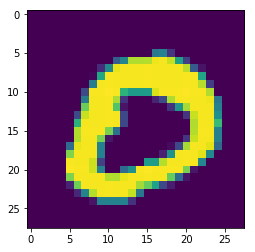

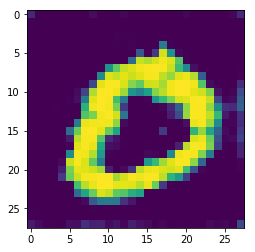

Epoch 2


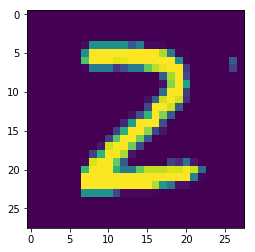

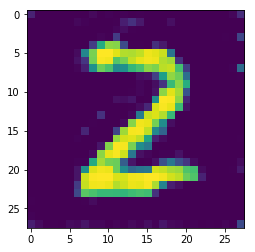

Epoch 3


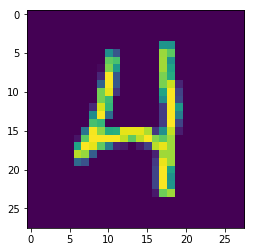

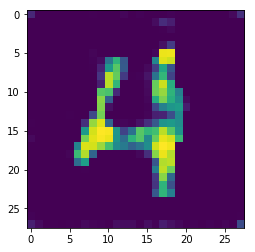

Epoch 4


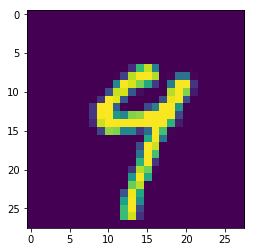

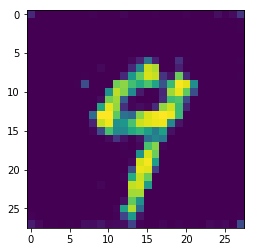

Epoch 5


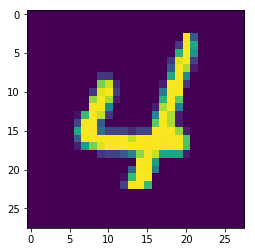

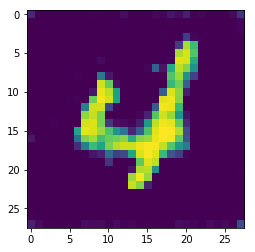

Epoch 6


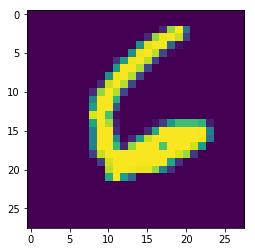

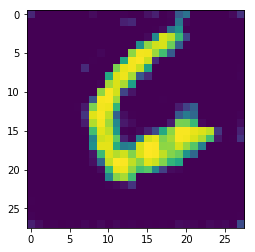

Epoch 7


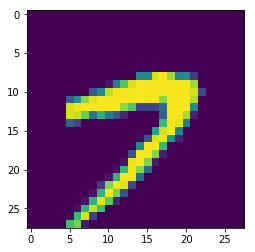

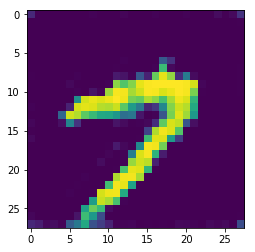

Epoch 8


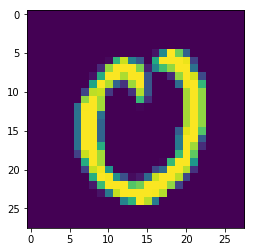

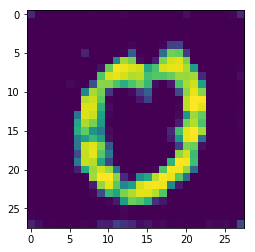

Epoch 9


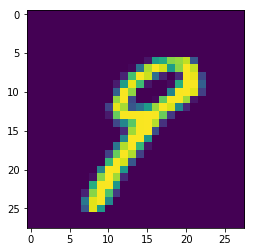

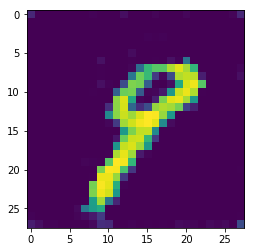

Epoch 10


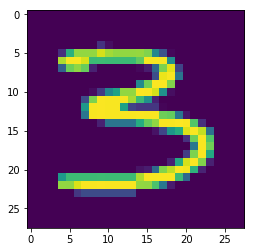

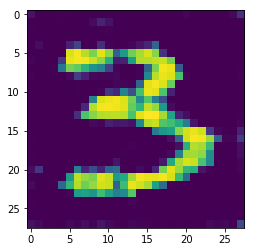

Epoch 11


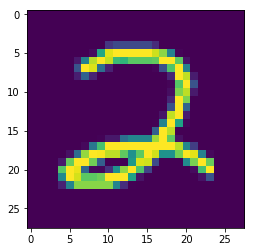

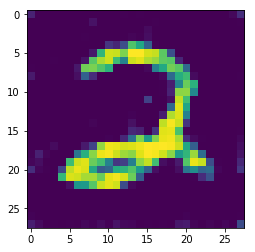

Epoch 12


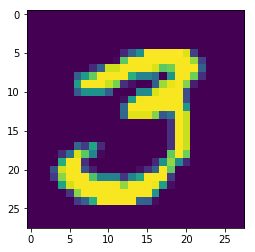

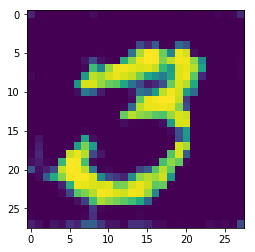

Epoch 13


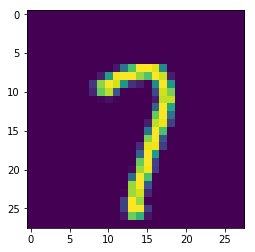

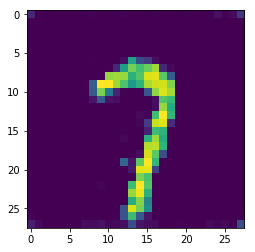

Epoch 14


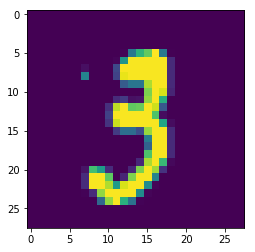

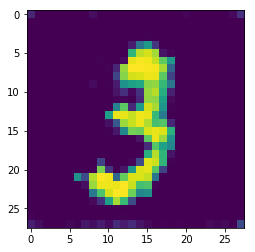

Epoch 15


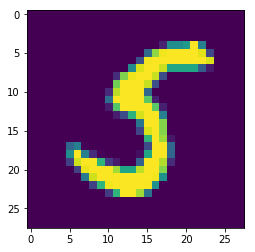

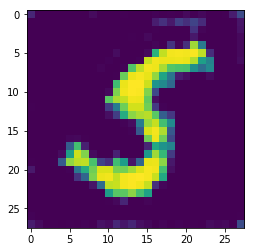

Epoch 16


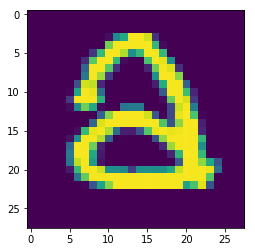

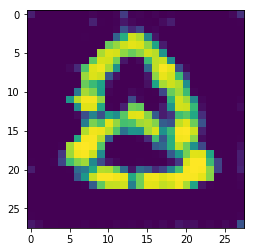

Epoch 17


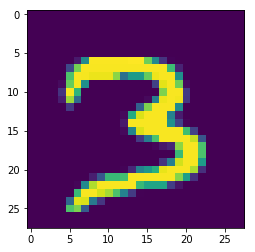

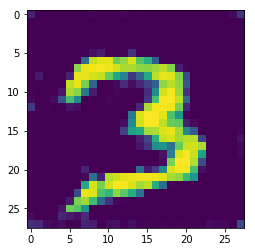

Epoch 18


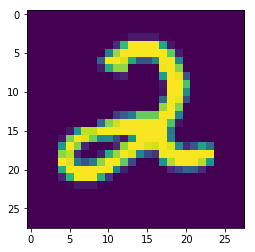

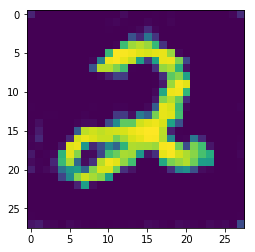

Epoch 19


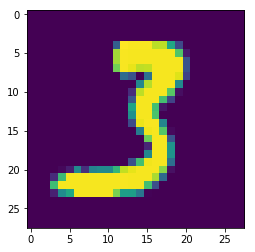

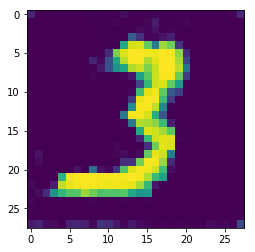

Epoch 20


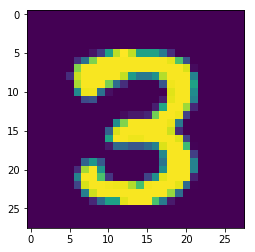

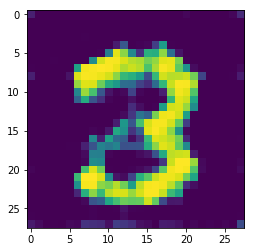

Epoch 21


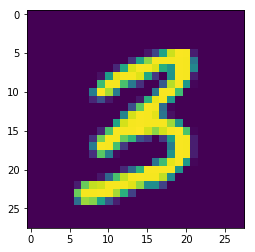

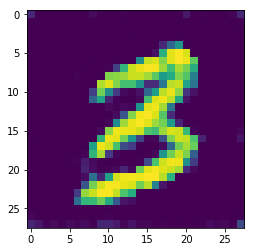

Epoch 22


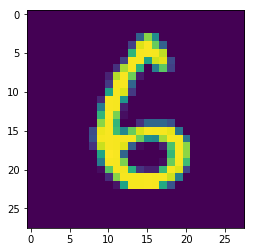

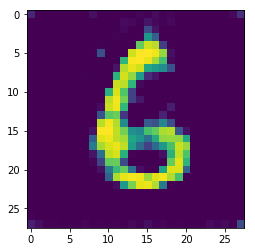

Epoch 23


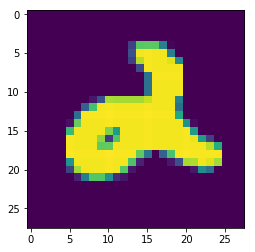

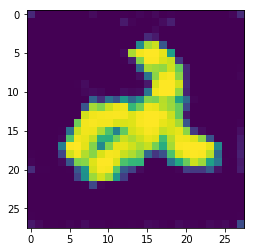

Epoch 24


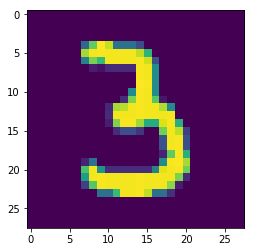

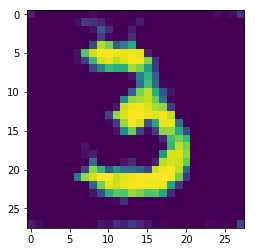

Epoch 25


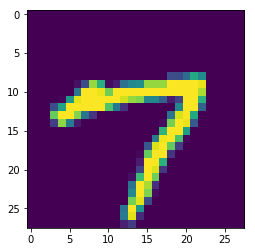

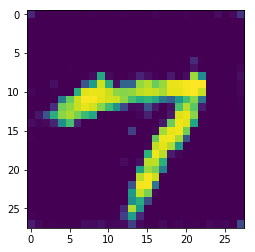

Epoch 26


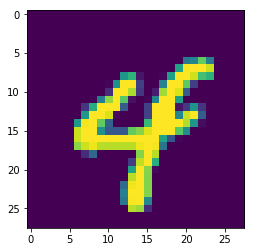

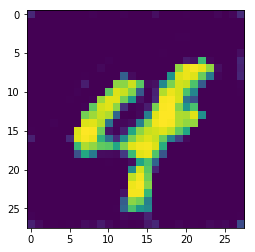

Epoch 27


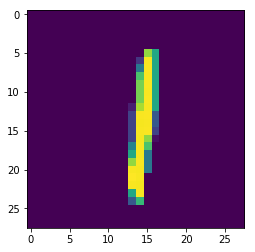

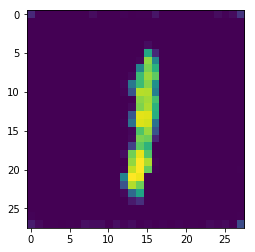

Epoch 28


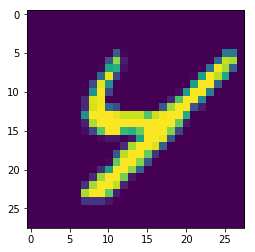

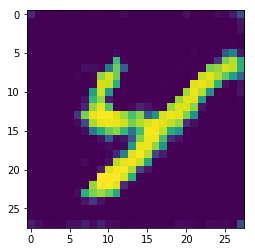

Epoch 29


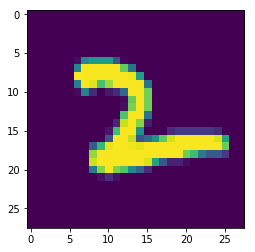

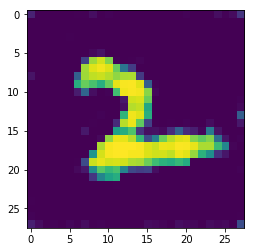

Epoch 30


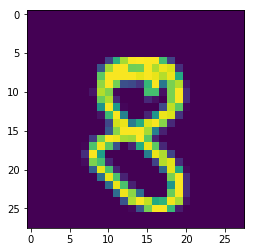

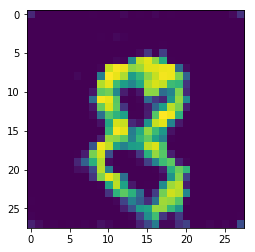

Epoch 31


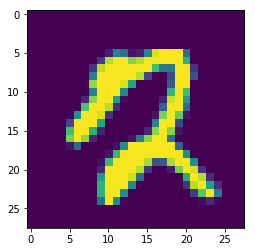

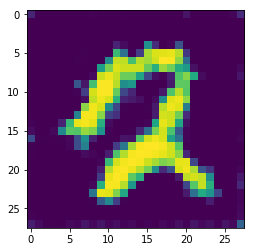

Epoch 32


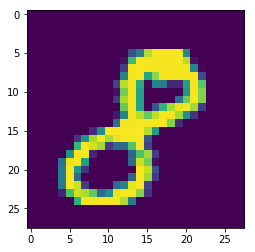

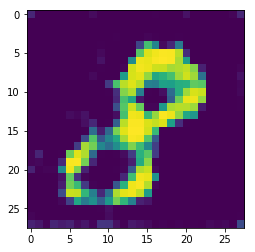

Epoch 33


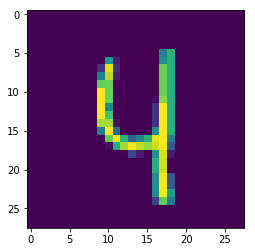

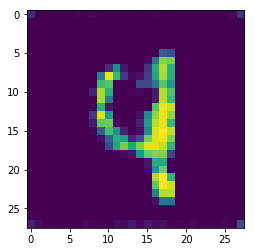

Epoch 34


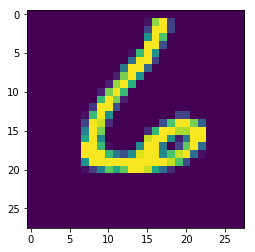

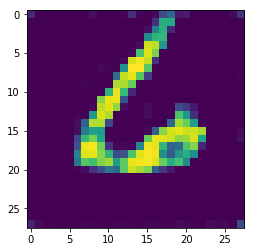

Epoch 35


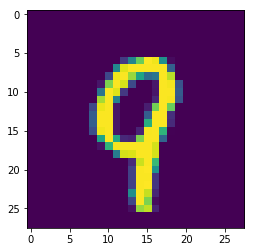

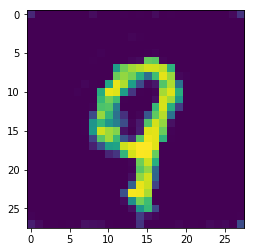

In [29]:
for e in range(epochs):
    print("Epoch {}".format(e+1))
    plt.imshow(inputs[e].numpy()[0])
    plt.show()
    plt.imshow(outputs[e].numpy()[0])
    plt.show()